In [94]:
%matplotlib inline
%pylab inline

mpl.rcParams['font.size']=12

from scipy.linalg import eig 
import bisect 
import copy

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Reproducing "Observations on the statistical iterations of matrices" by J.H. Hetherington*

## I. Introduction

We can use stochastic iteration to effect the power method for sampling the extremal eigenvalues/eigenvectors of a matrix with sampling access to a matrix-vector product. In the context of many-body physics, this matrix might be a Hamiltonian and we might be interested in, e.g, an approximation of the affiliated Green's function as in diffusion Monte Carlo.

Naive stochastic iteration can result in two effects that we would like to mitigate if we are to use it:

1. Seemingly anomalous growth in variance as the number of iterations increases.
2. Stable or reducing variance, but the introduction of bias.

In this notebook, we will walk through the results in Hetherington's paper and reproduce them one by one. This culminates in a simple stochastic reconfiguration implementation for controlling variance and bias with a fixed population of walkers.

*Fun fact: Hetherington is one of a select few physicists to have co-authored a paper with a domestic cat (https://en.wikipedia.org/wiki/F.D.C._Willard)

## II and III. Stochastic Matrices and Markov Chains

Most of us probably know what a stochastic matrix is. It is a matrix that is:
* Comprised of non-negative entries...
* ...and columns that sum to 1

We might interpret the entries of such a matrix as probabilities. The rows and columns of our matrix comprise a discrete state space through which we might imagine a system evolving. The entry in the ith row and jth column is then to be interpreted as the probability of the system transitioning into basis state i, given that it is found in basis state j.

What do we know about these matrices?
* They have a left eigenvector proportional to all 1s, with eigenvalue 1.
* 1 is the largest eigenvalue.
* If the matrix cannot be put in block diagonal form via permutation, this maximum eigenvalue is non-degenerate.

If we conceive of repeated application of this matrix as applying the power method to project out the largest eigenvector/eigenvalue of our matrix (which we assume to be non-degenerate), then the relationship between the properties of this type of matrix and the properties of a Markov Chain are evident. This largest eigenvector is, indeed, the stationary distribution of some Markov Chain. Thus, we see that there is a relationship between a Markov Chain generated by iterating some matrix and its extremal eigenvalues.

## IV. Non-negative Matrices

What happens if rather than considering matrices that are both non-negative and have columns that sum to unity, we consider more general non-negative matrices. We can factorize these matrices into a product of a stochastic matrix and a diagonal matrix. In Equation 2* of Hetherington's paper, he demonstrates that a non-negative matrix can be "made stochastic" given access to its extremal left eigenpair. Below we demonstrate how to do this for a contrived 2x2 example:

*Note: Equation 2 has a typo, it should be $M_{ij} = \frac{1}{\lambda} Z_i A_{ij} Z_{j}^{-1}$

In [95]:
# construct an exemplary non-negative matrix
A = zeros([2,2])
A[0,0] = 2.0
A[1,1] = 1.0
A[1,0] = 3.0
A[0,1] = 4.0
print 'Matrix A: \n', A

Matrix A: 
[[ 2.  4.]
 [ 3.  1.]]


In [96]:
# verify that columns do not sum to 1
print 'Column 0 sum: ', sum(A[:,0])
print 'Column 1 sum: ', sum(A[:,1])
print 'Matrix A is non-negative but the columns do not sum to 1'

Column 0 sum:  5.0
Column 1 sum:  5.0
Matrix A is non-negative but the columns do not sum to 1


In [97]:
# compute the eigenvalues and left/right eigenvectors
w, vl, vr = eig(A, left=True)

# fill out the entries of the stochastic part of A in the silliest way possible
# direct application of Equation 2
M = zeros([2,2])
scl = 1.0/abs(w[0])
M[0,0] = scl*vl[0,0]*A[0,0]/vl[0,0]
M[0,1] = scl*vl[0,0]*A[0,1]/vl[1,0]
M[1,0] = scl*vl[1,0]*A[1,0]/vl[0,0]
M[1,1] = scl*vl[1,0]*A[1,1]/vl[1,0]

print 'Stochastic factor of A (M): \n', M

Stochastic factor of A (M): 
[[ 0.4  0.8]
 [ 0.6  0.2]]


In [98]:
# compute the eigenvalues and left/right eigenvectors
wStoc, vlStoc, vrStoc = eig(M, left=True)

print 'Eigenvalues of M (largest is 1): ', wStoc 
print 'Left eigenvectors of M (eigenvector corresponding to 1 is ~ to all 1s): \n', vlStoc

Eigenvalues of M (largest is 1):  [ 1.0+0.j -0.4+0.j]
Left eigenvectors of M (eigenvector corresponding to 1 is ~ to all 1s): 
[[ 0.70710678 -0.6       ]
 [ 0.70710678  0.8       ]]


In [99]:
# compute the diagonal factor of A (below Equation 4)
wDiag = eye(2)
wDiag[0,0] *= sum(A[:,0])
wDiag[1,1] *= sum(A[:,1])

print 'Diagonal factor of A (w): \n', wDiag

Diagonal factor of A (w): 
[[ 5.  0.]
 [ 0.  5.]]


In [100]:
print 'Matrix A: \n', A
print 'Product M*w: \n', dot(M,wDiag)

Matrix A: 
[[ 2.  4.]
 [ 3.  1.]]
Product M*w: 
[[ 2.  4.]
 [ 3.  1.]]


## V. The Dilemma of the Symmetric Matrix

Of course, none of this is particularly useful as it assumes that we know the spectrum and eigenvectors a priori. Next we move onto the central example of the paper in which we estimate the largest eigenvalue of a symmetric non-negative matrix (something that is starting to look like a Hamiltonian).

## VI. Using Non-Stochastic Matrices

Assume for a moment that we have access to a factorized form of a symmetric, non-negative (but non-stochastic) matrix. We will demonstrate via stochastic iteration that we can estimate the largest eigenvalue of this matrix.

In [101]:
# create the SYMMETRIC A matrix of interest in the paper
A = zeros([2,2])
scl = 1.0/sqrt(6.0*4.0)
A[0,0] = scl*5
A[0,1] = scl*1
A[1,0] = scl*1
A[1,1] = scl*3

w, vl, vr = eig(A, left=True)
# we know that the eigenvalues are real, so just print them out as such
print 'Eigenvalues of A: ', real(w)
wExact = real(w[0])

Eigenvalues of A:  [ 1.10517172  0.52782145]


In [102]:
# create the diagonal factor of A
w = zeros([2,2])
w[0,0] = sum(A[:,0])
w[1,1] = sum(A[:,1])
print 'Diagonal factor of A: \n', w

Diagonal factor of A: 
[[ 1.22474487  0.        ]
 [ 0.          0.81649658]]


In [103]:
# create the stochastic factor of A
M = zeros([2,2])
M[0,0] = A[0,0]/w[0,0]
M[0,1] = A[0,1]/w[1,1]
M[1,0] = A[1,0]/w[0,0]
M[1,1] = A[1,1]/w[1,1]
print 'Stochastic factor of A: \n', M

Stochastic factor of A: 
[[ 0.83333333  0.25      ]
 [ 0.16666667  0.75      ]]


To estimate the largest eigenvector of A, we will now generate a Markov Chain from the probabilities in the stochastic factor, and weight the configurations with the respective elements of the diagonal factor. We will then take the estimate of the eigenvector, and extract its associated eigenvalue.

In [109]:
# the paper makes a point of using weights that are reciprocals, 
# such that the weight of a given configuration is (6/4)**(n/2)...
# given such a weight, this routine computes the integer n
def getN(weight):
    return int(log(weight**2)/log(6.0/4.0))

def estimateEig(nIterations, M, w):
    
    # starting from state 0
    currentState = 0

    weight = zeros(nIterations)
    weight[0] = 1.0 # start with a weight of 1

    nvec = zeros(nIterations) # for keeping track of the weight (in terms of its integer power) at each iteration
    nvec[0] = 0
    rvec = rand(nIterations-1)

    # for storing the running estimate of the largest eigenvector of A
    eigEst = zeros([2,nIterations])
    eigEst[0,0] = M[0,currentState]*weight[0]
    eigEst[1,0] = M[1,currentState]*weight[0]

    for i in range(1,nIterations):
    
        # the probability of staying in the current state is given by a diagonal element of the stochastic factor
        # ...and because this is a 2-state example, this is enough to constrain the probability of switching into the other state
        probStay = M[currentState,currentState]
    
        # if random number is greater than probability of staying, 
        # then for high probability of staying, probStay is close to 1 
        # and it is less likely that a number will be greater than probStay
        # so you should switch if this does happen
        if(rvec[i-1]>probStay):
            currentState = mod(currentState+1,2)            
    
        weight[i] = w[currentState,currentState]*weight[i-1]
    
        nvec[i] = getN(weight[i])
    
        eigEst[0,i] = eigEst[0,i-1] + M[0,currentState]*weight[i]
        eigEst[1,i] = eigEst[1,i-1] + M[1,currentState]*weight[i]
    
    return weight, eigEst

In [116]:
nIterations = 1000
weight, eigEst = estimateEig( nIterations, M, w )

# given the unnormalized eigenvector estimate, normalize it and compute the associated eigenvalue
# looks kind of like the local energy, yes?
nrmEst = sqrt(dot(eigEst[:,nIterations-1],eigEst[:,nIterations-1]))
eigNrm = eigEst[:,nIterations-1]/nrmEst
print 'Estimate of largest eigenvalue of A: ', dot(eigNrm,dot(A,eigNrm))
print 'Actual eigenvalue: ', wExact

Estimate of largest eigenvalue of A:  1.07595702368
Actual eigenvalue:  1.10517171552


This is a decent estimate, but not perfect. Looks good, right?

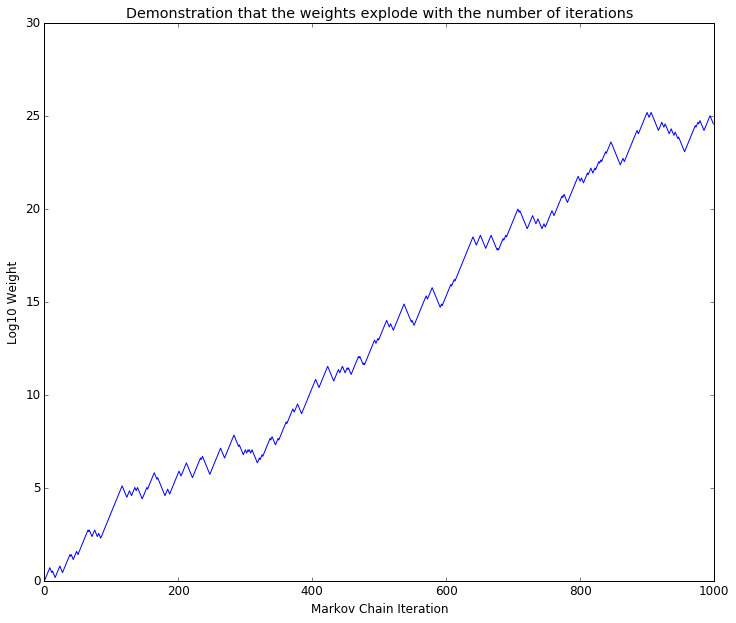

In [117]:
# weight vs iteration for the 1000 iteration Markov Chain
figure(figsize=[12,10])
plot(log10(weight))
xlabel('Markov Chain Iteration')
ylabel('Log10 Weight')
title('Demonstration that the weights explode with the number of iterations')

It turns out that the weights used in our Markov Chain explode, which means that we cannot carry this out indefinitely to reduce variance.

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


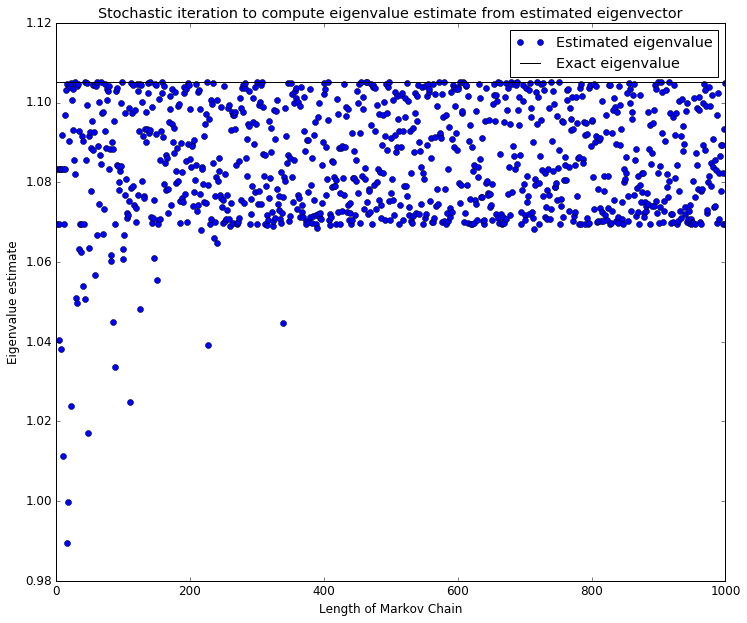

In [131]:
# vary the length of the Markov chain
iterationList = linspace(1,1000,1000)
wEstList = zeros(len(iterationList))
for idx,nIterations in enumerate(iterationList):
    weight, eigEst = estimateEig( int(nIterations), M, w )
    nrmEst = sqrt(dot(eigEst[:,nIterations-1],eigEst[:,nIterations-1]))
    eigNrm = eigEst[:,nIterations-1]/nrmEst
    wEstList[idx] = dot(eigNrm,dot(A,eigNrm))
    
# estimates vs length of Markov chain
figure(figsize=[12,10])
plot(iterationList, wEstList, 'o', label='Estimated eigenvalue')
axhline(wExact, color='black', label='Exact eigenvalue')
xlabel('Length of Markov Chain')
ylabel('Eigenvalue estimate')
title('Stochastic iteration to compute eigenvalue estimate from estimated eigenvector')    
legend()

Running this calculation for many different chain lengths, we see that increasing the chain length does not appear to generally make things better. Of course, this calculation is only for a single walker.

## VII. Difficulties Arise

Hetherington quantifies the difficulties that we are observing by plotting the distribution of weights in Figure 2. Let us reproduce this plot:

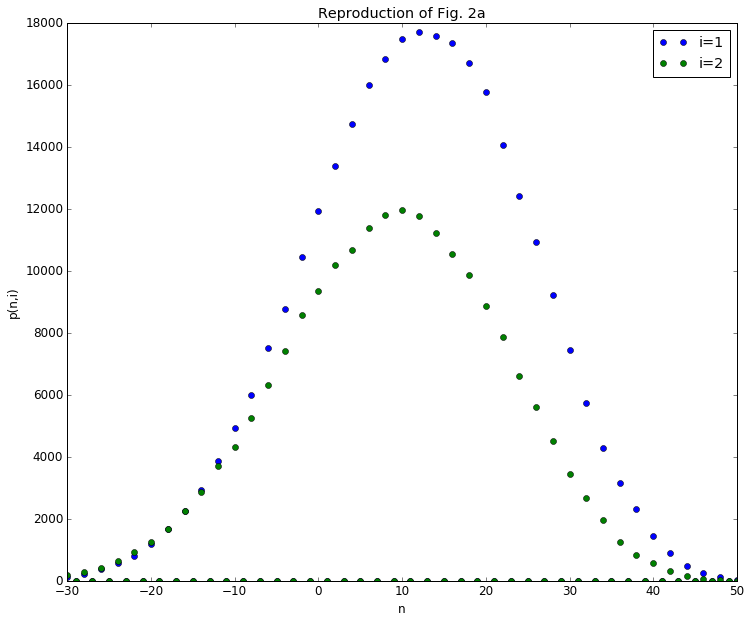

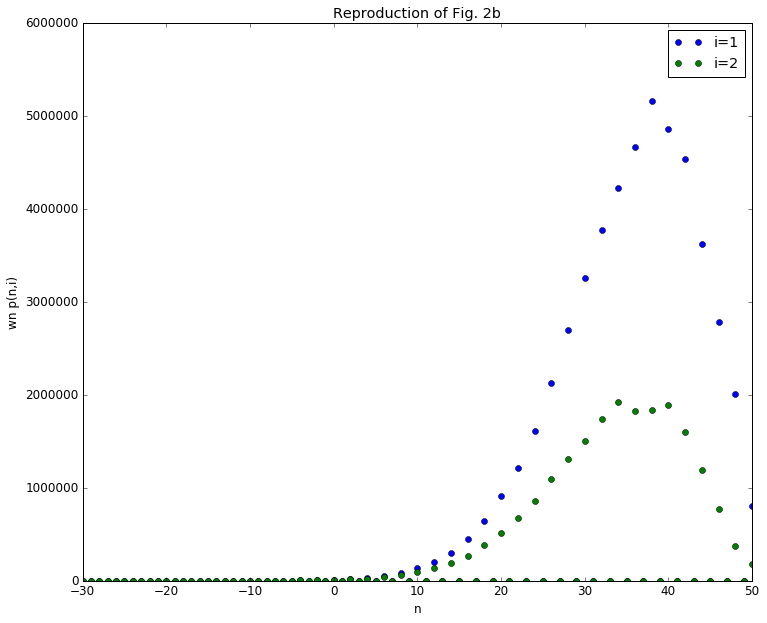

In [132]:
nWalkers = 500000
nIterations = 50

ensembleP = zeros([nIterations*2+1,2])

def getN(weight):
    return int(round(log(weight**2)/log(6.0/4.0)))

for walker in arange(nWalkers):

    # decide randomly on the initial state
    if(rand(1)<0.5):
        currentState = 0
        increment = True
    else:
        currentState = 1
        increment = False

    nvec = zeros(nIterations,dtype=int)
    nvec[0] = 0
    rvec = rand(nIterations-1)

    for i in range(1,nIterations):
    
        probStay = M[currentState,currentState]
   
        if(increment):
            nvec[i] = nvec[i-1] + 1
        else:
            nvec[i] = nvec[i-1] - 1

        if(rvec[i-1]>probStay):
            currentState = mod(currentState+1,2)    
            increment = not(increment)
    
    ensembleP[nIterations+1+nvec[-1],currentState] += 1.0 
    
n = linspace(-nIterations,nIterations,2*nIterations+1)
figure(figsize=[12,10])
plot(n,ensembleP[:,0], 'o', label='i=1')
plot(n,ensembleP[:,1], 'o', label='i=2')
xlabel('n')
ylabel('p(n,i)')
title('Reproduction of Fig. 2a')
legend()
xlim([-30,50])
figure(figsize=[12,10])
plot(n,ensembleP[:,0]*(1.5)**(n/2.), 'o', label='i=1')
plot(n,ensembleP[:,1]*(1.5)**(n/2.), 'o', label='i=2')
xlabel('n')
ylabel('wn p(n,i)')
title('Reproduction of Fig. 2b')
xlim([-30,50])    
legend()

An important thing to note in comparing this with the paper is that depending on the length of the Markov Chain (in this case 50) there are certain values of n that will never be reached. That is why every other entry (all of the even values of n) have proabability 0.

For the interested reader, it might be fun to watch the separation between these two sets of peaks grow as the length of the Markov Chain increases.

What is really important here? 
* The most probable answer is not the same as the average answer.
* The variance associated with estimators from this Markov chain will grow with the length of the chain. 
* The formal variance is non-monotonic in the length of the chain but it quickly turns over to exponential growth. This means that there is an optimal sequence length, beyond which continued iteration will help less than reducing statistical error by increasing the number of walkers.

Next we reproduce Figure 3. Here we demonstrate the the eigenvector estimate not only looks very different from the actual eigenvector, but that it does not resemble the eigenvector estimate predicted via matrix multiplication (i.e., deterministic power method).

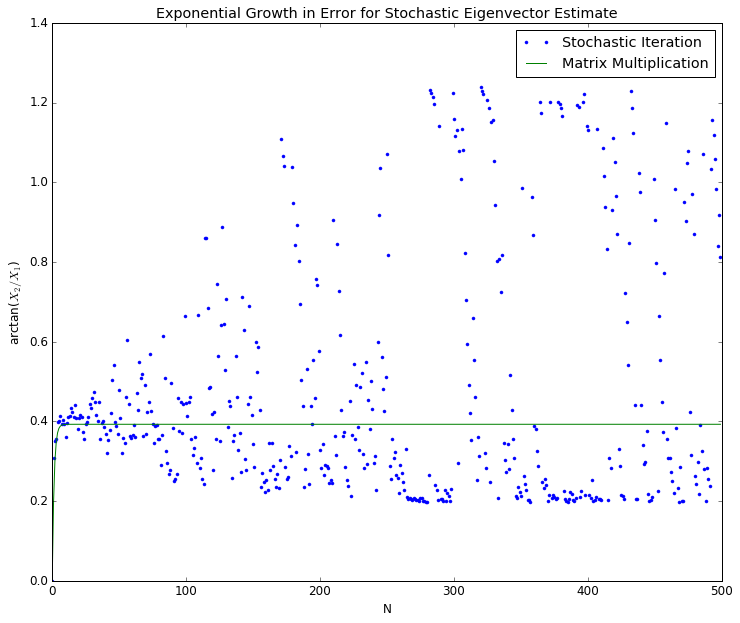

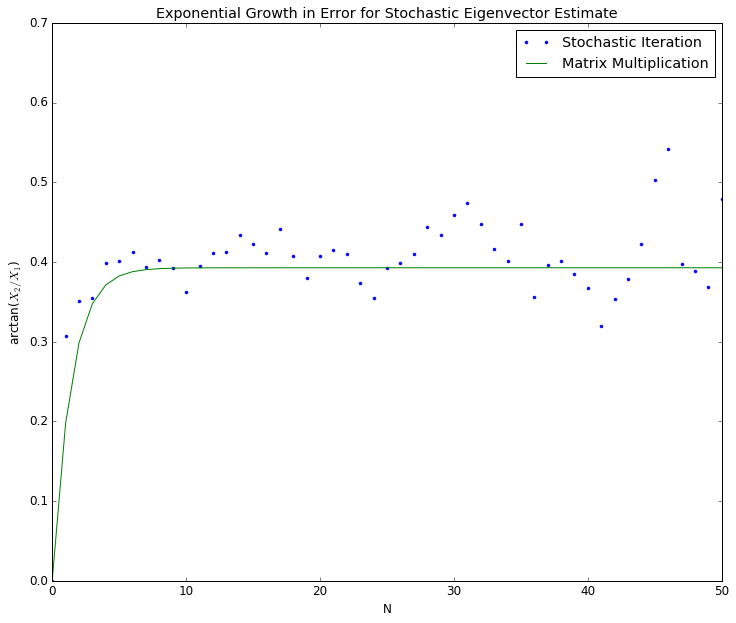

In [134]:
nWalkers = 512
nIterations = 500

ensembleX = zeros([nIterations,2])
ensembleX[0,0] = 1.0
ensembleX[0,1] = 0.0

def getN(weight):
    return int(round(log(weight**2)/log(6.0/4.0)))

for walker in arange(nWalkers):

    # do not decide randomly on the initial state, you know it is 0
    currentState = 0        
    
    nvec = zeros(nIterations,dtype=int)
    nvec[0] = 0
    rvec = rand(nIterations-1)
    weight = zeros(nIterations)
    weight[0] = 1.0

    for i in range(1,nIterations):
    
        probStay = M[currentState,currentState]
           
        if(rvec[i-1]>probStay):
            currentState = mod(currentState+1,2)    
               
        weight[i] = w[currentState,currentState]*weight[i-1]
        ensembleX[i,:] += M[:,currentState]*weight[i]        
        
analX = zeros([nIterations,2])
analX[0,0] = 1.0
analX[0,1] = 0.0

for i in range(1,nIterations):
    analX[i,:] = dot(A,analX[i-1,:])
    
figure(figsize=[12,10])
plot(arctan2(ensembleX[:,1],ensembleX[:,0]),'.', label='Stochastic Iteration')
plot(arctan2(analX[:,1],analX[:,0]), '-', label='Matrix Multiplication')
xlabel('N')
ylabel('arctan($X_2/X_1$)')
title('Exponential Growth in Error for Stochastic Eigenvector Estimate')
legend()

figure(figsize=[12,10])
xlim([0,50])
ylim([0,0.7])
plot(arctan2(ensembleX[:,1],ensembleX[:,0]),'.', label='Stochastic Iteration')
plot(arctan2(analX[:,1],analX[:,0]), '-', label='Matrix Multiplication')
xlabel('N')
ylabel('arctan($X_2/X_1$)')
title('Exponential Growth in Error for Stochastic Eigenvector Estimate')    
legend()

## VIII. The Weighted Average

Rather than using the eigenvector itself to compute the eigenvalue estimate, this section introduces a functional form for an estimator. We use it to reproduce Figure 4.

In [135]:
def weightedAverage( L, nTrials ):
    
    nIterations = 20000

    M = zeros([2,2])
    M[0,0] = 5./6.
    M[0,1] = 1./4.
    M[1,0] = 1./6.
    M[1,1] = 3./4.
        
    w = zeros([2,2])    
    w[0,0] = sqrt(6./4.)
    w[1,1] = sqrt(4./6.)
    
    lambdaEsts = zeros(nTrials)
    
    for trial in arange(nTrials):

        # do not decide randomly on the initial state, you know it is 0
        currentState = 0        
        
        Gnvec = zeros(nIterations)
        wvec = zeros(nIterations)
        rvec = rand(nIterations)
        weightList = []
        
        cweight = w[currentState,currentState]
        wvec[0] = cweight
        Gnvec[0] = 1.0        
        weightList.append( cweight )

        for i in range(1,nIterations):
                        
            probStay = M[currentState,currentState]
           
            if(rvec[i]>probStay):
                currentState = mod(currentState+1,2)    
               
            cweight = w[currentState,currentState]            
            wvec[i] = cweight
            
            if(L==0):
                Gnvec[i] = 1.0
            else:                
                Gnvec[i] = reduce( lambda x, y: x*y, weightList )
            
            weightList.append(cweight)
            if(len(weightList)>L):
                weightList.pop(0)
            
        lambdaEsts[trial] = dot(wvec,Gnvec)/sum(Gnvec)
    
    return mean(lambdaEsts), var(lambdaEsts)

In [136]:
# this guy will take like 5 minutes to run
Lvals = [0,1,2,3,4,5,6,7,12,18,20,24,30,35,41,48]
NL = len(Lvals)
lammeans = zeros(NL)
lamvars = zeros(NL)
for idx,L in enumerate(Lvals):
    lammeans[idx], lamvars[idx] = weightedAverage( L, 50 )

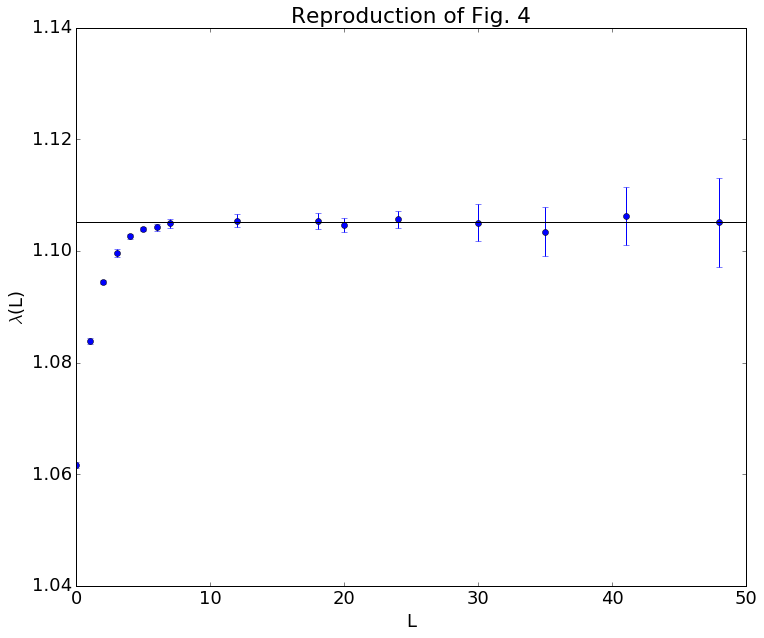

In [137]:
figure(figsize=[12,10])
errorbar(Lvals, lammeans, yerr=100*lamvars,fmt='o',label='Stochastic Estimate')
axhline(1.10517,color='black', label='Exact Eigenvalue')
ylim([1.04,1.14])
mpl.rcParams['font.size']=18
xlabel('L')
ylabel('$\lambda$(L)')
title('Reproduction of Fig. 4')

Here we see the fundamental tradeoff that we have to deal with. Even for a Markov Chain with 20,000 iterations we have a choice between problems:

* If we truncate the product of weights to L<10, we have small variance but statistical bias.
* If we let the product of weights increase to encompass the whole chain, the variance will grow exponentially with L.

Reconfiguration is the solution to this problem.

## IX, X, and XI. Carrying Many Configurations Simultaneously (and More)

The solution to these problems is to carry many walkers together, and to assign a global weight to the group of walkers. The algorithm implemented goes through the following:

* Create a population of walkers and sum up their total weight.
    * Randomly move each walker individually as before.
    * Compute the population averaged weight, which will be used in the estimator.
    * Choose to copy (or not copy) walkers among this fixed population based upon their relative weights.
    * Repeat.

The basic idea here is that a single walker is liable to have weights that explode. Rather than relying on these individual weights, we aggregate them every so often (in this case every iteration) and reconfigure the walker population relative to their cumulative weights. This has the net effect of damping out huge fluctuations in the weights, while introducing a statistical bias that scales inversely with the walker population.

In [139]:
# the input variables are:
#  -L : number of iterations to average over
#  -M : population
#  -N : length of Markov chain
#  -S : S+1 = number of configurations to average over at the end of the chain
def stochasticReconfiguration( L, M, N, S ):
    
    # p = the probabilities of staying in state 0 or 1
    p = zeros(2)
    w = zeros(2)
    p[0] = 5./6.
    p[1] = 3./4.
    
    # the weights affiliated with states 0 and 1
    w[0] = sqrt(6./4.)
    w[1] = sqrt(4./6.)
    
    # all walkers start in state 0
    popStates = zeros(M)  
    popWeights = w[0]*ones(M)
    
    # allocate the global weight 
    globalWeight = zeros(N+1) 
    # initialize for the first iteration
    globalWeight[0] = w[0]
    
    
    # iterate over the length of the Markov chain
    for i in range(1,N+1):
        
        # compute a set of random numbers for testing each moving in the population, at this iteration
        rvec = rand(M)
        # accumulate population weight
        totalWeight = 0.0
        
        # accumulate the global weight
        for walker in range(M):
            cState = popStates[walker]
            if(rvec[walker]>p[cState]):
                popStates[walker] = mod(cState+1,2)
            popWeights[walker] = w[cState]
            totalWeight += w[cState]
        globalWeight[i] = totalWeight/float(M)
        
        # reconfigure
        cumWeights = cumsum(popWeights)     
        rvec = rand(M)
        tmpStates = copy.deepcopy(popStates)
        tmpWeights = copy.deepcopy(popWeights)
        for walker in range(M):
            choice = bisect.bisect( cumWeights, rvec[walker]*totalWeight )
            popStates[walker] = tmpStates[choice]
            popWeights[walker] = tmpWeights[choice]
        
    Gvec = zeros(S+1)
    for s in range(0,S+1):
        Gvec[s] = prod( globalWeight[N-s-L:N-s] )
        
    lambdaEst = dot(globalWeight[N-S:],Gvec)/sum(Gvec)
        
    return lambdaEst, globalWeight

In [157]:
# nTrials for statistics
nTrials = 10

# 2,000 samples per test
LList = [0,1,2,3,4,5,6,7,12,18,20,24,30,35,41,48]
LEst = zeros(len(LList))
LVar = zeros(len(LList))

for idx,pop in enumerate(LList):
    
    trialResults = zeros(nTrials)
    M = 30
    N = 2000
    for trial in range(nTrials):
        lE, gW = stochasticReconfiguration(L, M, N, N-1)
        trialResults[trial] = lE
    
    LEst[idx] = mean(trialResults)
    LVar[idx] = var(trialResults)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(1.04, 1.14)

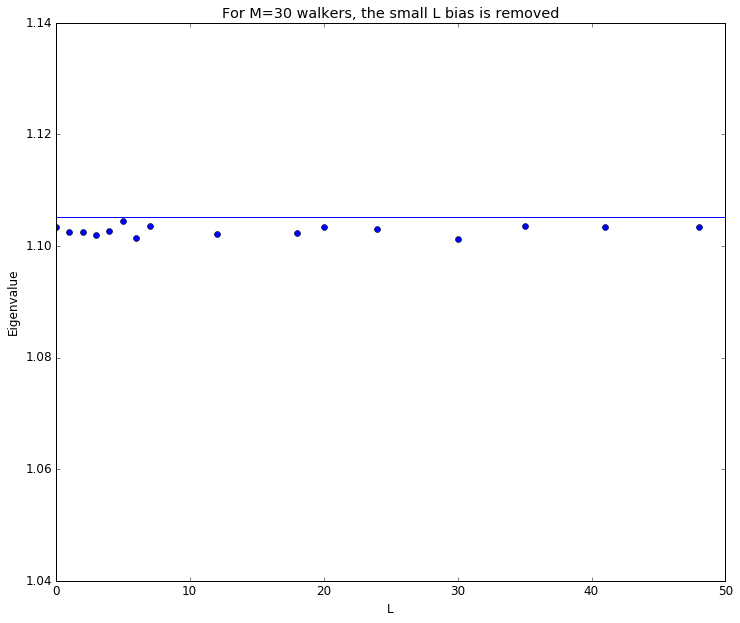

In [158]:
figure(figsize=[12,10])
mpl.rcParams['font.size']=12
errorbar( LList, LEst, yerr=LVar, fmt='o' )
axhline(1.10517)
xlabel('L')
ylabel('Eigenvalue')
title('For M=30 walkers, the small L bias is removed')
ylim([1.04,1.14])

In [159]:
# nTrials for statistics
nTrials = 10

# 2,000 samples per test
LList = [0,1,2,3,4,5,6,7,12,18,20,24,30,35,41,48]
LEst = zeros(len(LList))
LVar = zeros(len(LList))

for idx,pop in enumerate(LList):
    
    trialResults = zeros(nTrials)
    M = 2
    N = 2000
    for trial in range(nTrials):
        lE, gW = stochasticReconfiguration(L, M, N, N-1)
        trialResults[trial] = lE
    
    LEst[idx] = mean(trialResults)
    LVar[idx] = var(trialResults)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(1.04, 1.14)

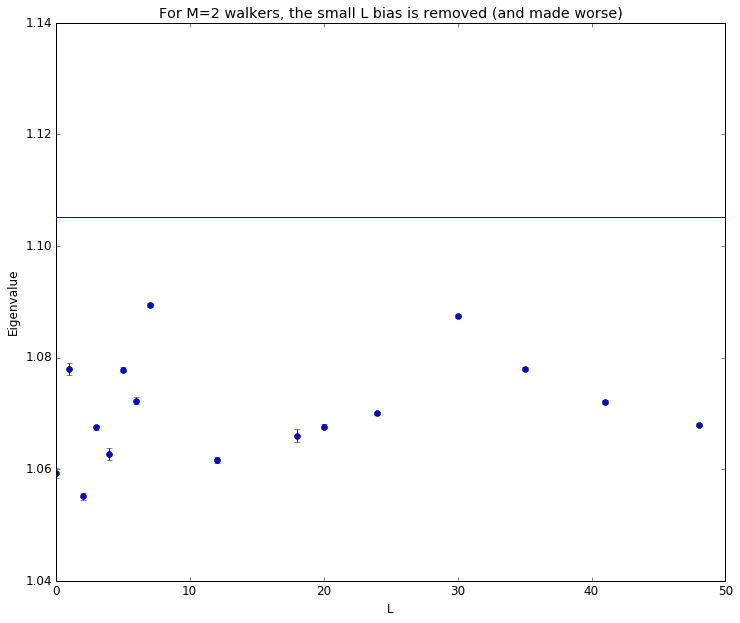

In [161]:
figure(figsize=[12,10])
mpl.rcParams['font.size']=12
errorbar( LList, LEst, yerr=LVar, fmt='o' )
axhline(1.10517)
xlabel('L')
ylabel('Eigenvalue')
title('For M=2 walkers, the small L bias is removed (and made worse)')
ylim([1.04,1.14])